# Описание проекта
В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
try:
    df = pd.read_csv('/datasets/real_estate_data.csv', delimiter='\t')
except: df = pd.read_csv('/datasets/real_estate_data.csv', delimiter='\t')

In [3]:
pd.set_option('max_columns', None) # для корректного вывода без скрытых столбцов 

## Обзор данных

In [4]:
df.head()


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

In [6]:
df.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition'],
      dtype='object')

In [7]:
df.rename(columns={'cityCenters_nearest':'city_centers_dist',
                   'last_price':'price', 
                   'airports_nearest':'airports_dist',
                   'parks_around3000':'parks_3km',
                   'parks_nearest':'parks_dist',
                   'ponds_around3000':'ponds_3km',
                   'ponds_nearest':'ponds_dist'                                  
                   
                  }, inplace=True)

In [8]:
df.dtypes

total_images              int64
price                   float64
total_area              float64
first_day_exposition     object
rooms                     int64
ceiling_height          float64
floors_total            float64
living_area             float64
floor                     int64
is_apartment             object
studio                     bool
open_plan                  bool
kitchen_area            float64
balcony                 float64
locality_name            object
airports_dist           float64
city_centers_dist       float64
parks_3km               float64
parks_dist              float64
ponds_3km               float64
ponds_dist              float64
days_exposition         float64
dtype: object

Необходимо изменить некторые типы данных, но перед этим нужно обработать пропуски

In [9]:
df.describe()

,total_images,price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_dist,city_centers_dist,parks_3km,parks_dist,ponds_3km,ponds_dist,days_exposition
count,23699.000000,2.369900e+04,23699.000000,23699.000000,14504.000000,23613.000000,21796.000000,23699.000000,21421.000000,12180.000000,18157.000000,18180.000000,18181.000000,8079.000000,18181.000000,9110.000000,20518.000000
mean,9.858475,6.541549e+06,60.348651,2.070636,2.771499,10.673824,34.457852,5.892358,10.569807,1.150082,28793.672193,14191.277833,0.611408,490.804555,0.770255,517.980900,180.888634
std,5.682529,1.088701e+07,35.654083,1.078405,1.261056,6.597173,22.030445,4.885249,5.905438,1.071300,12630.880622,8608.386210,0.802074,342.317995,0.938346,277.720643,219.727988
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.520000,5.000000,18.600000,2.000000,7.000000,0.000000,18585.000000,9238.000000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,1.000000,26726.000000,13098.500000,0.000000,455.000000,1.000000,502.000000,95.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.800000,16.000000,42.300000,8.000000,12.000000,2.000000,37273.000000,16293.000000,1.000000,612.000000,1.000000,729.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


In [10]:
df.duplicated().sum()

0

Отсутствуют дубликаты. Во многих переменных есть пропуски данных, которые необходимо обработать.

## Работа с пропусками и артефактами

### высота потолков пропуски

In [11]:
print('пропущенных значений до:', df['ceiling_height'].isna().sum())
df.loc[df['ceiling_height'].isna(), 'ceiling_height']= df['ceiling_height'].median()
print('пропущенных значений после:', df['ceiling_height'].isna().sum())


пропущенных значений до: 9195
пропущенных значений после: 0


In [12]:
df.loc[df['ceiling_height'] == 1, 'ceiling_height']= df['ceiling_height'].median()
df.loc[df['ceiling_height'] > 5, 'ceiling_height']= df['ceiling_height'].median()
df['ceiling_height'].value_counts()

2.65    9908
2.50    3515
2.60    1646
2.70    1574
3.00    1112
        ... 
3.88       1
2.25       1
4.37       1
3.68       1
2.49       1
Name: ceiling_height, Length: 163, dtype: int64

Пропущенные значения. а так же некорректные значения равные 1 и более 5 по переменной высота потолков заменены на медианные 

### Общая площадь пропуски

In [13]:

print('пропуски до:', df['living_area'].isna().sum())
for rooms in df['rooms'].unique():
    median = df.loc[df['rooms'] == rooms, 'living_area'].median()
    print(rooms, median)
    df.loc[(df['living_area'].isna()) & (df['rooms'] == rooms), 'living_area'] = median



print('пропуски после:', df['living_area'].isna().sum())


пропуски до: 1903
3 45.0
1 17.6
2 30.5
4 63.6
5 91.785
6 123.9
0 18.0
7 145.0
11 133.9
8 161.0
14 195.15
10 161.4
15 409.0
9 179.2
19 264.5
16 180.0
12 409.7
пропуски после: 0


Пропущенные значения по переменной жилая прощадь были сгрупированы по признаку кол-во комнат и заменены на мединное значение площади.

In [14]:
df.groupby('rooms')['living_area'].transform('median')

0        45.0
1        17.6
2        30.5
3        45.0
4        30.5
         ... 
23694    45.0
23695    45.0
23696    30.5
23697    30.5
23698    17.6
Name: living_area, Length: 23699, dtype: float64

In [15]:
df.groupby('rooms')['living_area'].median()

rooms
0      18.000
1      17.600
2      30.500
3      45.000
4      63.600
5      91.785
6     123.900
7     145.000
8     161.000
9     179.200
10    161.400
11    133.900
12    409.700
14    195.150
15    409.000
16    180.000
19    264.500
Name: living_area, dtype: float64

### апартаменты пропуски

In [16]:
df['is_apartment'].fillna(False, inplace = True)


Если явно не указано на апартаменты, значит не апартаменты.

### площадь кухни пропуски

In [17]:
print('площадь кухни пропуски до:', df['kitchen_area'].isna().sum())


площадь кухни пропуски до: 2278


In [18]:
df['kitchen_area'].min()


1.3

In [19]:
print('кол-во открытых планировок:',len(df.loc[df['open_plan']==True]))
print('отсутствует площадь кухни в открытых планировках:'
      ,df.loc[df['open_plan']==True, 'kitchen_area'].isna().sum())

кол-во открытых планировок: 67
отсутствует площадь кухни в открытых планировках: 67


In [20]:
df.loc[df['studio'] == True, 'kitchen_area'] = 0
df.loc[df['open_plan'] == True, 'kitchen_area'] = 0

In [21]:
print('площадь кухни пропуски после:', df['kitchen_area'].isnull().sum())

площадь кухни пропуски после: 2062


У всех студий и квартир с открытой планировкой были пропущены значения площади кухни, которые были заменены на ноль. В остальных квартирах кухня должна быть больше нуля


In [22]:
df_kitchen = df.query('kitchen_area != 0') 
kitchen_median = (df_kitchen['kitchen_area'] / df_kitchen['total_area']).median()
print('медианная доля площади кухни от общей площади составляет:{:.1%}'.format(kitchen_median))

медианная доля площади кухни от общей площади составляет:17.2%


In [23]:
df['kitchen_area'].fillna(df['total_area'] * kitchen_median, inplace = True) 
print('площадь кухни пропуски после:', df['kitchen_area'].isnull().sum())

площадь кухни пропуски после: 0


пропущеные значения заменены на долю кухни от общей площади

### кол-во балконов пропуски

In [24]:
print('среднее кол-во балконов, не считая 1этаж:', df.loc[df['floor']!= 1, 'balcony'].mean())
print ('уникальные значения кол-ва балконов на всех этажах кроме первого:', df['balcony'].value_counts())


среднее кол-во балконов, не считая 1этаж: 1.1890249352042184
уникальные значения кол-ва балконов на всех этажах кроме первого: 1.0    4195
0.0    3758
2.0    3659
5.0     304
4.0     183
3.0      81
Name: balcony, dtype: int64


In [25]:
print('кол-во балконов пропуски до:', df['balcony'].isna().sum()) 
df.loc[(df['balcony'].isna()) & (df['floor']== 1), 'balcony'] = 0
print('кол-во балконов пропуски после замены на 0 балконов для первых этажей:', df['balcony'].isna().sum())






кол-во балконов пропуски до: 11519
кол-во балконов пропуски после замены на 0 балконов для первых этажей: 9593


In [26]:
df_balcony = df[df['floor']!=1]
print(df_balcony['balcony'].unique())
df_balcony

[nan  0.  1.  2.  5.  4.  3.]


,total_images,price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_dist,city_centers_dist,parks_3km,parks_dist,ponds_3km,ponds_dist,days_exposition
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,False,False,False,25.000000,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
2,10,5196000.0,56.00,2015-08-20T00:00:00,2,2.65,5.0,34.3,4,False,False,False,8.300000,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.00,2015-07-24T00:00:00,3,2.65,14.0,45.0,9,False,False,False,27.413793,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,False,False,False,41.000000,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,2.65,12.0,14.4,5,False,False,False,9.100000,NaN,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23692,2,1350000.0,30.00,2017-07-07T00:00:00,1,2.65,5.0,17.5,4,False,False,False,6.000000,NaN,Тихвин,NaN,NaN,NaN,NaN,NaN,NaN,413.0
23693,9,4600000.0,62.40,2016-08-05T00:00:00,3,2.60,9.0,40.0,8,False,False,False,8.000000,0.0,Петергоф,45602.0,34104.0,1.0,352.0,1.0,675.0,239.0
23694,9,9700000.0,133.81,2017-03-21T00:00:00,3,3.70,5.0,73.3,3,False,False,False,13.830000,NaN,Санкт-Петербург,24665.0,4232.0,1.0,796.0,3.0,381.0,NaN
23695,14,3100000.0,59.00,2018-01-15T00:00:00,3,2.65,5.0,38.0,4,False,False,False,8.500000,NaN,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,45.0


In [27]:
df_balcony.loc[df_balcony['rooms']==3, 'balcony'].mean()

1.3344494047619047

In [28]:
for rooms in df_balcony['rooms'].unique():
    median = df_balcony.loc[df_balcony['rooms']==rooms, 'balcony'].median()
    print(rooms, median)
    df.loc[(df['balcony'].isna()) & (df['rooms']== rooms), 'balcony'] = median
print('кол-во балконов пропуски после:', df['balcony'].isna().sum())

3 1.0
2 1.0
1 1.0
4 1.0
5 1.0
6 1.0
0 2.0
7 1.0
11 nan
8 0.0
14 0.0
10 1.0
15 nan
9 0.5
19 nan
16 1.0
12 nan
кол-во балконов пропуски после: 5


/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


По некоторым значениям кол-ва комнат не удалось рассчитать медиану т.к. в них отсутствуют значения ко-ва балконов.

In [29]:
df['balcony'].value_counts()

1.0    13712
0.0     5690
2.0     3720
5.0      304
4.0      183
3.0       81
0.5        4
Name: balcony, dtype: int64

In [30]:
df[df['balcony']==0.5]

,total_images,price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_dist,city_centers_dist,parks_3km,parks_dist,ponds_3km,ponds_dist,days_exposition
8860,12,17000000.0,235.0,2018-07-14T00:00:00,9,3.0,6.0,179.2,3,False,False,False,40.517241,0.5,Санкт-Петербург,24466.0,5034.0,1.0,346.0,0.0,NaN,90.0
9550,10,23500000.0,313.0,2017-02-13T00:00:00,9,3.2,6.0,179.2,5,False,False,False,13.200000,0.5,Санкт-Петербург,38435.0,10138.0,1.0,146.0,0.0,NaN,NaN
13019,0,22250000.0,249.9,2019-04-23T00:00:00,9,3.2,5.0,157.0,5,False,False,False,12.400000,0.5,Санкт-Петербург,10328.0,9987.0,2.0,352.0,0.0,NaN,NaN
20791,0,24000000.0,250.0,2019-04-23T00:00:00,9,3.2,5.0,160.6,3,False,False,False,11.700000,0.5,Санкт-Петербург,10328.0,9987.0,2.0,352.0,0.0,NaN,NaN


In [31]:
df[df['rooms']==9]


,total_images,price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_dist,city_centers_dist,parks_3km,parks_dist,ponds_3km,ponds_dist,days_exposition
8822,14,49968900.0,398.0,2017-07-12T00:00:00,9,3.00,2.0,160.1,1,False,False,False,41.000000,0.0,Санкт-Петербург,17720.0,16722.0,3.0,471.0,2.0,440.0,471.0
8860,12,17000000.0,235.0,2018-07-14T00:00:00,9,3.00,6.0,179.2,3,False,False,False,40.517241,0.5,Санкт-Петербург,24466.0,5034.0,1.0,346.0,0.0,NaN,90.0
9550,10,23500000.0,313.0,2017-02-13T00:00:00,9,3.20,6.0,179.2,5,False,False,False,13.200000,0.5,Санкт-Петербург,38435.0,10138.0,1.0,146.0,0.0,NaN,NaN
13019,0,22250000.0,249.9,2019-04-23T00:00:00,9,3.20,5.0,157.0,5,False,False,False,12.400000,0.5,Санкт-Петербург,10328.0,9987.0,2.0,352.0,0.0,NaN,NaN
13397,14,19500000.0,309.7,2016-02-03T00:00:00,9,2.65,5.0,199.0,5,False,False,False,14.300000,0.0,Санкт-Петербург,10328.0,9987.0,2.0,352.0,0.0,NaN,468.0
15151,15,88000000.0,400.0,2019-03-27T00:00:00,9,2.50,2.0,250.0,1,False,False,False,50.000000,0.0,Санкт-Петербург,24395.0,2725.0,2.0,315.0,1.0,578.0,NaN
16915,14,29000000.0,292.2,2017-01-12T00:00:00,9,3.35,5.0,225.9,4,False,False,False,32.900000,1.0,Санкт-Петербург,24892.0,5162.0,2.0,263.0,0.0,NaN,825.0
20791,0,24000000.0,250.0,2019-04-23T00:00:00,9,3.20,5.0,160.6,3,False,False,False,11.700000,0.5,Санкт-Петербург,10328.0,9987.0,2.0,352.0,0.0,NaN,NaN


In [32]:
df.loc[df['balcony']== 0.5, 'balcony'] = 1

In [33]:
df[df['balcony'].isna()]

,total_images,price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_dist,city_centers_dist,parks_3km,parks_dist,ponds_3km,ponds_dist,days_exposition
648,3,17500000.0,183.7,2018-07-01T00:00:00,11,3.40,7.0,138.8,7,False,False,False,13.3,NaN,Санкт-Петербург,23606.0,3148.0,0.0,NaN,0.0,NaN,NaN
5358,20,65000000.0,590.0,2019-02-14T00:00:00,15,3.50,6.0,409.0,3,False,False,False,100.0,NaN,Санкт-Петербург,24447.0,4666.0,1.0,767.0,0.0,NaN,14.0
9688,8,33000000.0,194.1,2017-02-07T00:00:00,11,3.43,5.0,129.0,2,False,False,False,11.9,NaN,Санкт-Петербург,21469.0,1015.0,1.0,686.0,2.0,66.0,813.0
14498,6,32250000.0,374.6,2018-06-09T00:00:00,19,2.65,5.0,264.5,2,False,False,False,27.6,NaN,Санкт-Петербург,19497.0,3574.0,0.0,NaN,2.0,548.0,114.0
19540,8,420000000.0,900.0,2017-12-06T00:00:00,12,2.80,25.0,409.7,25,False,False,False,112.0,NaN,Санкт-Петербург,30706.0,7877.0,0.0,NaN,2.0,318.0,106.0


In [34]:
df.loc[df['rooms']>10, 'balcony'].mean()

0.3333333333333333

Осталось 5 пропусков это строки для которых не подсчитано мединное значения для замены с группировкой по кол-ву комнат. Заменим их на 1 т.к даже в квартирах с более чем 10 комнат среднее значение балконов меньше одного.

In [35]:
df['balcony'].fillna(1, inplace = True)
print('пропуски после:', df['balcony'].isna().sum())

пропуски после: 0


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
price                   23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          23699 non-null float64
floors_total            23613 non-null float64
living_area             23699 non-null float64
floor                   23699 non-null int64
is_apartment            23699 non-null bool
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            23699 non-null float64
balcony                 23699 non-null float64
locality_name           23650 non-null object
airports_dist           18157 non-null float64
city_centers_dist       18180 non-null float64
parks_3km               18181 non-null float64
parks_dist              8079 non-null float64
ponds_3km       

### всего этажей пропуски

In [37]:
df[df['floors_total'].isna()]

,total_images,price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_dist,city_centers_dist,parks_3km,parks_dist,ponds_3km,ponds_dist,days_exposition
186,12,11640000.0,65.2,2018-10-02T00:00:00,2,2.65,NaN,30.80,4,False,False,False,12.000000,1.0,Санкт-Петербург,39197.0,12373.0,1.0,123.0,0.0,NaN,49.0
237,4,2438033.0,28.1,2016-11-23T00:00:00,1,2.65,NaN,20.75,1,False,False,False,4.844828,0.0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,251.0
457,4,9788348.0,70.8,2015-08-01T00:00:00,2,2.65,NaN,38.40,12,False,False,False,10.630000,0.0,Санкт-Петербург,37364.0,8322.0,2.0,309.0,2.0,706.0,727.0
671,4,6051191.0,93.6,2017-04-06T00:00:00,3,2.65,NaN,47.10,8,False,False,False,16.800000,0.0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,123.0
1757,5,3600000.0,39.0,2017-04-22T00:00:00,1,2.65,NaN,17.60,9,False,False,False,6.724138,0.0,Санкт-Петербург,22735.0,11618.0,1.0,835.0,1.0,652.0,77.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22542,5,8500000.0,63.5,2017-05-24T00:00:00,2,2.80,NaN,30.50,3,False,False,False,10.948276,1.0,Санкт-Петербург,51340.0,15363.0,0.0,NaN,1.0,853.0,512.0
22656,4,4574160.0,64.5,2017-04-02T00:00:00,2,2.65,NaN,31.70,20,False,False,False,14.400000,0.0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,127.0
22808,0,14569263.0,110.4,2016-11-20T00:00:00,3,2.65,NaN,45.38,6,False,False,False,23.420000,0.0,Санкт-Петербург,19095.0,4529.0,0.0,NaN,0.0,NaN,260.0
23590,0,21187872.0,123.3,2017-04-25T00:00:00,3,2.65,NaN,50.40,18,False,False,False,23.600000,0.0,Санкт-Петербург,19095.0,4529.0,0.0,NaN,0.0,NaN,104.0


In [38]:
df.loc[df['floors_total'].isna(), 'floors_total' ] = df['floor']
df.loc[[457]] 


,total_images,price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_dist,city_centers_dist,parks_3km,parks_dist,ponds_3km,ponds_dist,days_exposition
457,4,9788348.0,70.8,2015-08-01T00:00:00,2,2.65,12.0,38.4,12,False,False,False,10.63,0.0,Санкт-Петербург,37364.0,8322.0,2.0,309.0,2.0,706.0,727.0


Пропуски в значении всего этажей заменены на значения этажа указанного в объявлении.

### Наименование населенного пункта пропуски

In [39]:
print(df['locality_name'].isna().sum())

49


In [40]:
df.loc[df['locality_name'].isna()]

,total_images,price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_dist,city_centers_dist,parks_3km,parks_dist,ponds_3km,ponds_dist,days_exposition
1097,3,8600000.0,81.70,2016-04-15T00:00:00,3,3.55,5.0,50.80,2,False,False,False,8.800000,0.0,NaN,23478.0,4258.0,0.0,NaN,0.0,NaN,147.0
2033,6,5398000.0,80.00,2017-05-30T00:00:00,3,2.65,4.0,42.60,2,False,False,False,18.600000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.0
2603,20,3351765.0,42.70,2015-09-20T00:00:00,1,2.65,24.0,15.60,3,False,False,False,10.700000,0.0,NaN,22041.0,17369.0,0.0,NaN,1.0,374.0,276.0
2632,2,5130593.0,62.40,2015-10-11T00:00:00,2,2.65,24.0,33.10,21,False,False,False,8.200000,0.0,NaN,22041.0,17369.0,0.0,NaN,1.0,374.0,256.0
3574,10,4200000.0,46.50,2016-05-28T00:00:00,2,2.65,5.0,30.80,5,False,False,False,6.500000,0.0,NaN,27419.0,8127.0,0.0,NaN,1.0,603.0,45.0
4151,17,17600000.0,89.50,2014-12-09T00:00:00,2,3.00,8.0,39.62,7,False,False,False,13.380000,0.0,NaN,25054.0,3902.0,1.0,485.0,3.0,722.0,869.0
4189,7,9200000.0,80.00,2015-12-10T00:00:00,3,4.00,4.0,52.30,3,False,False,False,10.400000,0.0,NaN,21774.0,3039.0,1.0,690.0,1.0,953.0,223.0
4670,1,5500000.0,83.00,2015-08-14T00:00:00,3,2.65,7.0,45.00,6,False,False,False,14.310345,0.0,NaN,26534.0,5382.0,1.0,446.0,1.0,376.0,350.0
5343,19,13540000.0,85.50,2016-01-20T00:00:00,3,2.65,7.0,59.10,5,False,False,False,8.300000,4.0,NaN,10556.0,9538.0,1.0,67.0,0.0,NaN,303.0
5707,7,3700000.0,30.00,2016-04-29T00:00:00,1,2.65,24.0,20.00,23,False,False,False,5.172414,0.0,NaN,21460.0,16788.0,0.0,NaN,1.0,170.0,49.0


Протяжённость города с восток на запад — 25 км, с севера на юг — 52 км, если расстояние до центра менее 12.5км(половина от минимальной протяженности), то вероятнее всего это Санкт-Петербург

In [41]:
df.loc[(df['locality_name'].isna()) & (df['city_centers_dist']< 12500), 'locality_name' ] = 'Санкт-Петербург'
print('пропуски до:',df['locality_name'].isna().sum())
df['locality_name'].dropna(inplace=True)
print('пропуски после:',df['locality_name'].isna().sum())

пропуски до: 21
пропуски после: 0


Оставшиеся 21 пропуск в наименовании населенного пункта мы вынуждены удалить т.к. определить местоположение не представляется возможным, а дальнейший анализ без данной переменной не имеет смысла.

### Расстояния пропуски

In [42]:
print(df['airports_dist'].isna().sum())
print(df['city_centers_dist'].isna().sum())
print(df['parks_dist'].isna().sum())
print(df['ponds_dist'].isna().sum())

5542
5519
15620
14589


In [43]:
print('пропуски до:', df['parks_dist'].isna().sum())
df.loc[(df['parks_dist'].isna()) & (df['parks_3km']>0), 'parks_dist'] = 3000
print('пропуски после:', df['parks_dist'].isna().sum())


пропуски до: 15620
пропуски после: 15620


нет пропущенных значений в данных где есть парк в пределах 3км. это значит что все пропущенные значения более 3км, либо данные имеют пропуски по обеим переменным.

In [44]:
df[df['parks_dist']>3000]

,total_images,price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_dist,city_centers_dist,parks_3km,parks_dist,ponds_3km,ponds_dist,days_exposition
1590,3,7500000.0,70.0,2017-07-11T00:00:00,2,2.65,18.0,37.0,13,False,False,False,10.0,0.0,Санкт-Петербург,14878.0,9791.0,0.0,3064.0,1.0,264.0,4.0
10959,9,3000000.0,31.1,2017-03-21T00:00:00,1,2.65,5.0,17.7,2,False,False,False,5.5,0.0,Санкт-Петербург,14821.0,9734.0,0.0,3190.0,1.0,431.0,234.0
19208,17,14950000.0,187.0,2017-10-12T00:00:00,5,3.00,2.0,80.0,2,False,False,False,17.0,1.0,Санкт-Петербург,36805.0,8656.0,0.0,3013.0,3.0,537.0,49.0
19430,9,3900000.0,30.5,2018-02-22T00:00:00,1,2.60,5.0,16.5,1,False,False,False,5.5,0.0,Санкт-Петербург,14821.0,9734.0,0.0,3190.0,1.0,431.0,176.0


In [45]:
df['parks_dist'].describe()

count    8079.000000
mean      490.804555
std       342.317995
min         1.000000
25%       288.000000
50%       455.000000
75%       612.000000
max      3190.000000
Name: parks_dist, dtype: float64

In [46]:
df.loc[(df['parks_dist'].isna()) & (df['parks_3km'].isna())]

,total_images,price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_dist,city_centers_dist,parks_3km,parks_dist,ponds_3km,ponds_dist,days_exposition
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,2.65,12.0,14.40,5,False,False,False,9.100000,1.0,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,2.65,27.0,15.43,26,False,False,False,8.810000,1.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
12,10,3890000.0,54.00,2016-06-30T00:00:00,2,2.65,5.0,30.00,5,False,False,False,9.000000,0.0,Сертолово,NaN,NaN,NaN,NaN,NaN,NaN,90.0
22,20,5000000.0,58.00,2017-04-24T00:00:00,2,2.75,25.0,30.00,15,False,False,False,11.000000,2.0,деревня Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,60.0
30,12,2200000.0,32.80,2018-02-19T00:00:00,1,2.65,9.0,17.60,2,False,False,False,5.655172,1.0,Коммунар,NaN,NaN,NaN,NaN,NaN,NaN,63.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23683,16,2100000.0,62.80,2018-09-18T00:00:00,4,2.50,5.0,45.50,3,False,False,False,5.500000,1.0,посёлок Дзержинского,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23692,2,1350000.0,30.00,2017-07-07T00:00:00,1,2.65,5.0,17.50,4,False,False,False,6.000000,1.0,Тихвин,NaN,NaN,NaN,NaN,NaN,NaN,413.0
23695,14,3100000.0,59.00,2018-01-15T00:00:00,3,2.65,5.0,38.00,4,False,False,False,8.500000,1.0,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,45.0
23696,18,2500000.0,56.70,2018-02-11T00:00:00,2,2.65,3.0,29.70,1,False,False,False,9.775862,0.0,село Рождествено,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Оставшиеся пропущеные значения в переменных связанных с растоянием оставим пропущенными

### Кол-во дней публикации объявления пропуски

In [47]:
df['days_exposition'].isna().sum()


3181

In [48]:
print(df.loc[df['days_exposition'].isna()])


       total_images       price  total_area first_day_exposition  rooms  \
0                20  13000000.0      108.00  2019-03-07T00:00:00      3   
7                 5   7915000.0       71.60  2019-04-18T00:00:00      2   
44               13   5350000.0       40.00  2018-11-18T00:00:00      1   
45               17   5200000.0       50.60  2018-12-02T00:00:00      2   
46               17   6600000.0       52.10  2019-01-31T00:00:00      2   
...             ...         ...         ...                  ...    ...   
23684            20  21400000.0      145.00  2018-11-02T00:00:00      4   
23685            15   2490000.0       31.00  2019-01-24T00:00:00      1   
23694             9   9700000.0      133.81  2017-03-21T00:00:00      3   
23696            18   2500000.0       56.70  2018-02-11T00:00:00      2   
23698             4   1350000.0       32.30  2017-07-21T00:00:00      1   

       ceiling_height  floors_total  living_area  floor  is_apartment  studio  \
0                2

Пропущенные значения по кол-ву дней экспозиции может означать что объявление еще не снято с публикации.

## Изменение типа данных

In [49]:
df.dtypes

total_images              int64
price                   float64
total_area              float64
first_day_exposition     object
rooms                     int64
ceiling_height          float64
floors_total            float64
living_area             float64
floor                     int64
is_apartment               bool
studio                     bool
open_plan                  bool
kitchen_area            float64
balcony                 float64
locality_name            object
airports_dist           float64
city_centers_dist       float64
parks_3km               float64
parks_dist              float64
ponds_3km               float64
ponds_dist              float64
days_exposition         float64
dtype: object

In [50]:
df['airports_dist'].fillna(-1, inplace=True)
df['airports_dist'] = df['airports_dist'].astype('int64')
df.loc[df['airports_dist']== -1, 'airports_dist']= None

df['city_centers_dist'].fillna(-1, inplace=True) 
df['city_centers_dist'] = df['city_centers_dist'].astype('int64')
df.loc[df['city_centers_dist']== -1, 'city_centers_dist']= None

df['parks_3km'].fillna(-1, inplace=True)
df['parks_3km'] = df['parks_3km'].astype('int64')
df.loc[df['parks_3km']== -1, 'parks_3km']= None

df['parks_dist'].fillna(-1, inplace=True)
df['parks_dist'] = df['parks_dist'].astype(np.int64)
df.loc[df['parks_dist']== -1, 'parks_dist']= None

df['ponds_3km'].fillna(-1, inplace=True)
df['ponds_3km'].astype('int64')
df.loc[df['ponds_3km']== -1, 'ponds_3km']= None


df['ponds_dist'].fillna(-1, inplace=True)
df['ponds_dist'] = df['ponds_dist'].astype('int64')
df.loc[df['ponds_dist']== -1, 'ponds_dist']= None

df['days_exposition'].fillna(-1, inplace=True)
df['days_exposition'] = df['days_exposition'].astype('int64')
df.loc[df['days_exposition']== -1, 'days_exposition']= None


In [51]:
df.dtypes

total_images              int64
price                   float64
total_area              float64
first_day_exposition     object
rooms                     int64
ceiling_height          float64
floors_total            float64
living_area             float64
floor                     int64
is_apartment               bool
studio                     bool
open_plan                  bool
kitchen_area            float64
balcony                 float64
locality_name            object
airports_dist           float64
city_centers_dist       float64
parks_3km               float64
parks_dist              float64
ponds_3km               float64
ponds_dist              float64
days_exposition         float64
dtype: object

Пока не разобрался как перевести в int если есть Nan

In [52]:
df.head()

,total_images,price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_dist,city_centers_dist,parks_3km,parks_dist,ponds_3km,ponds_dist,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,False,False,False,25.000000,1.0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,2.65,11.0,18.6,1,False,False,False,11.000000,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,2.65,5.0,34.3,4,False,False,False,8.300000,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,2.65,14.0,45.0,9,False,False,False,27.413793,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,False,False,False,41.000000,1.0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [53]:
df['price'] = df['price'].astype('int64')
df['total_area'] = df['total_area'].astype('int64')
df['floors_total'] = df['floors_total'].astype('int64')
df['balcony'] = df['balcony'].astype('int64')


In [54]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

In [55]:
df.dtypes

total_images                     int64
price                            int64
total_area                       int64
first_day_exposition    datetime64[ns]
rooms                            int64
ceiling_height                 float64
floors_total                     int64
living_area                    float64
floor                            int64
is_apartment                      bool
studio                            bool
open_plan                         bool
kitchen_area                   float64
balcony                          int64
locality_name                   object
airports_dist                  float64
city_centers_dist              float64
parks_3km                      float64
parks_dist                     float64
ponds_3km                      float64
ponds_dist                     float64
days_exposition                float64
dtype: object

In [56]:
df['locality_name'].value_counts()

Санкт-Петербург                  15749
посёлок Мурино                     522
посёлок Шушары                     440
Всеволожск                         398
Пушкин                             369
                                 ...  
деревня Большое Рейзино              1
деревня Нижние Осельки               1
поселок Тёсово-4                     1
садовое товарищество Садко           1
посёлок Пансионат Зелёный Бор        1
Name: locality_name, Length: 364, dtype: int64

## Добавление переменных

In [57]:
df.head(5)

,total_images,price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_dist,city_centers_dist,parks_3km,parks_dist,ponds_3km,ponds_dist,days_exposition
0,20,13000000,108,2019-03-07,3,2.70,16,51.0,8,False,False,False,25.000000,1,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000,40,2018-12-04,1,2.65,11,18.6,1,False,False,False,11.000000,2,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000,56,2015-08-20,2,2.65,5,34.3,4,False,False,False,8.300000,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000,159,2015-07-24,3,2.65,14,45.0,9,False,False,False,27.413793,0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000,100,2018-06-19,2,3.03,14,32.0,13,False,False,False,41.000000,1,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [58]:
df['price_m2'] = df['price'] / df['total_area']

In [59]:
df['price_m2'] = df['price_m2'].astype('int64')

In [60]:
df['% living_area'] = df['total_area'] / df['living_area']

In [61]:
df['% kitchen_area'] = df['total_area'] / df['kitchen_area']

In [62]:
df['floor_type'] = 0
df['floor_type'].loc[df['floor'] == 1] = 'first'
df['floor_type'].loc[df['floor'] == df['floors_total']] = 'last'
df['floor_type'].loc[df['floor_type'] == 0] = 'other'


/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [63]:
# провека разбиения на категории этажей
print (df['floor_type'].unique())

['other' 'first' 'last']


In [64]:
df['first_day_expo_D'] = df['first_day_exposition'].dt.weekday + 1
df['first_day_expo_Y'] = df['first_day_exposition'].dt.year
df['first_day_expo_M'] = df['first_day_exposition'].dt.month

## Изучение переменных


In [65]:
print (df.head(10))

   total_images     price  total_area first_day_exposition  rooms  \
0            20  13000000         108           2019-03-07      3   
1             7   3350000          40           2018-12-04      1   
2            10   5196000          56           2015-08-20      2   
3             0  64900000         159           2015-07-24      3   
4             2  10000000         100           2018-06-19      2   
5            10   2890000          30           2018-09-10      1   
6             6   3700000          37           2017-11-02      1   
7             5   7915000          71           2019-04-18      2   
8            20   2900000          33           2018-05-23      1   
9            18   5400000          61           2017-02-26      3   

   ceiling_height  floors_total  living_area  floor  is_apartment  studio  \
0            2.70            16        51.00      8         False   False   
1            2.65            11        18.60      1         False   False   
2        

### Общая площадь 

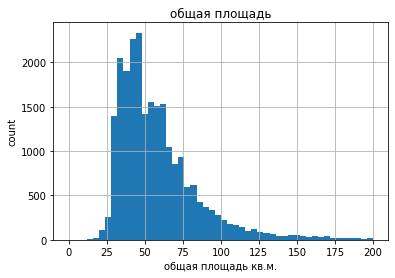

In [66]:
plt.title("общая площадь")
plt.xlabel("общая площадь кв.м.")
plt.ylabel("count")
df['total_area'].hist(bins = 50, range = (0, 200));


In [67]:
df['total_area'].describe() 

count    23699.000000
mean        60.120511
std         35.665822
min         12.000000
25%         40.000000
50%         52.000000
75%         69.000000
max        900.000000
Name: total_area, dtype: float64

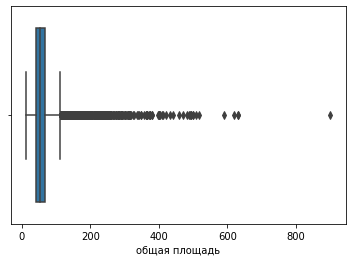

In [68]:
ax=sns.boxplot(df['total_area']);
ax.set(xlabel='общая площадь');


Наблюдается много выбросов или редко встечающихся значений

[Text(0.5, 0, 'Общая площадь.')]

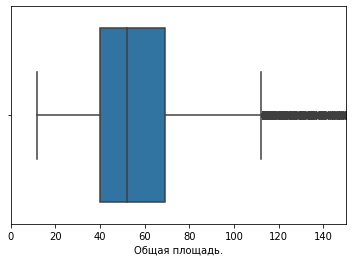

In [69]:
plt.xlim(0, 150)
ax=sns.boxplot(df['total_area']);
ax.set(xlabel='Общая площадь.')


На графике выше видно распределение по площади продаваемых квартир. Основная масса продаваемых квартир имеет площадь 40-70кв.м.


### Цена



In [70]:
df.head(10)
df['price'] = df['price']/1e6

цену на квартиры удобнее считать в миллионах

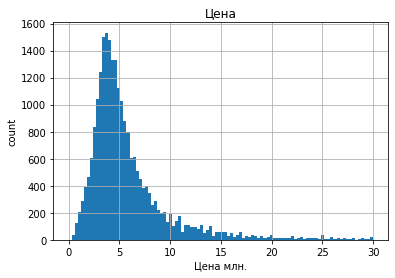

In [71]:
plt.title("Цена")
plt.xlabel("Цена млн.")
plt.ylabel("count")
df['price'].hist(bins = 100, range = (0, 30));

[Text(0.5, 0, 'Цена млн.')]

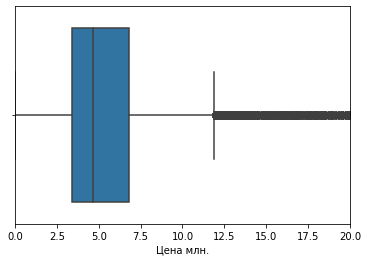

In [72]:
plt.xlim(0, 20)
ax=sns.boxplot(df['price']);
ax.set(xlabel='Цена млн.')



In [73]:
df['price'].describe()

count    23699.000000
mean         6.541549
std         10.887013
min          0.012190
25%          3.400000
50%          4.650000
75%          6.800000
max        763.000000
Name: price, dtype: float64

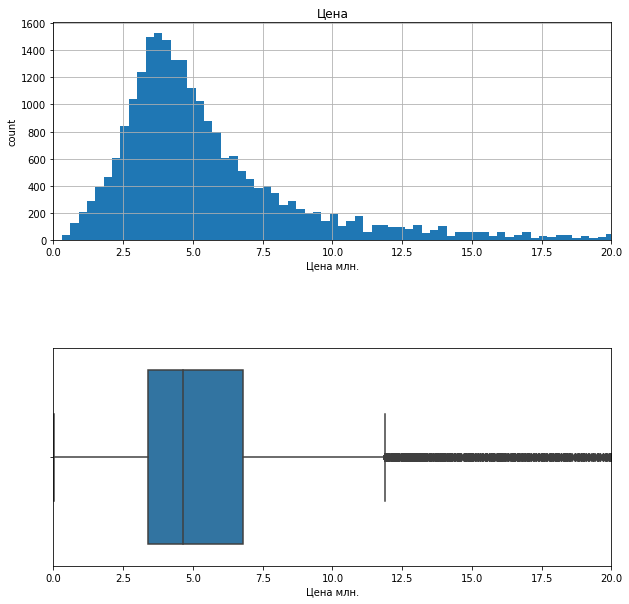

In [74]:
def price(df, title):
    plt.subplot(2, 1, 1)
    plt.title(title)
    plt.xlabel("Цена млн.")
    plt.ylabel("count")
    df['price'].hist(bins = 100, range = (0, 30), figsize=(10,10));
    plt.subplots_adjust(hspace=0.5) 
    plt.xlim(0, 20)
    plt.subplot(2, 1, 2, sharex = plt.gca())
    ax=sns.boxplot(df['price']);
    ax.set(xlabel='Цена млн.')
price(df, "Цена")


Разброс цен по всему набору данных очень велик, но основная масса укладывается в диапазон цен от 3.4 млн до 6.7 млн.

### Число комнат


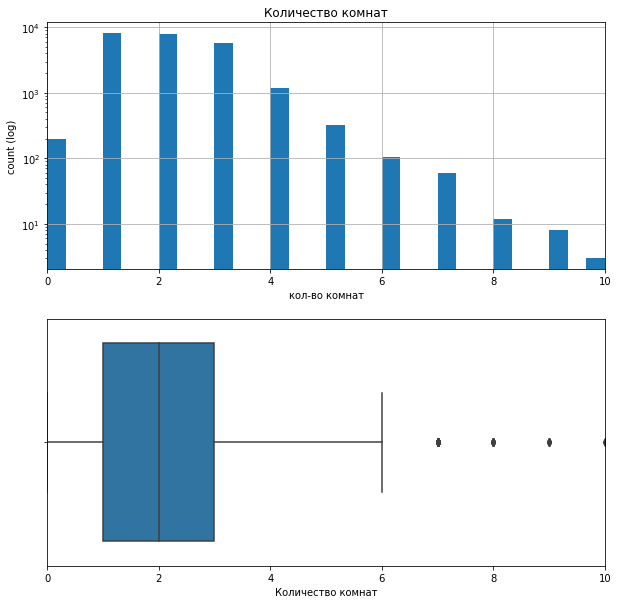

In [75]:
def rooms(df,title):
    plt.subplot(2, 1, 1)
    plt.yscale('log')
    plt.title(title)
    plt.xlabel("кол-во комнат")
    plt.ylabel("count (log)")
    df['rooms'].hist(bins = 30, range = (0, 10), rwidth=1, figsize=(10,10));
    plt.xlim(0, 10)
    plt.subplot(2, 1, 2, sharex = plt.gca())
    ax=sns.boxplot(df['rooms']);
    ax.set(xlabel='Количество комнат')
    df['rooms'].describe() 
rooms(df, 'Количество комнат')


In [76]:
df.loc[df['rooms']==0]
df.groupby('rooms')['total_area'].agg(['describe'])

describe                                                             
         count        mean         std    min     25%    50%     75%    max
rooms                                                                      
0        197.0   29.081218   25.864512   15.0   24.00   26.0   28.00  371.0
1       8047.0   37.406860    9.340667   12.0   32.00   36.0   41.00  494.0
2       7940.0   55.625945   13.193164   20.0   46.00   53.0   62.00  196.0
3       5814.0   77.543000   23.279958   40.0   62.00   73.0   87.00  363.0
4       1180.0  107.394068   44.539885   42.0   77.00   99.0  125.00  500.0
5        326.0  161.306748   69.347982   40.0  117.25  146.0  183.75  507.0
6        105.0  201.342857   77.798906   87.0  152.00  184.0  236.00  500.0
7         59.0  265.169492  130.128206  100.0  181.50  214.0  347.00  631.0
8         12.0  259.083333   69.857593  150.0  224.25  235.5  323.75  373.0
9          8.0  305.750000   64.342277  235.0  249.75  300.5  334.25  400.0
10         3.0  259.333333   38.591882  216.0  244.00  272.0  281.00  290.0
11         2.0  188.500000    7.778175  183.0  185.75  188.5  191.25  194.0
12         1.0  900.000000         NaN  900.0  900.00  900.0  900.00  900.0
14         2.0  304.000000   83.438600  245.0  274.50  304.0  333.50  363.0
15         1.0  590.000000         NaN  590.0  590.00  590.0  590.00  590.0
16         1.0  270.000000         NaN  270.0  270.00  270.0  270.00  270.0
19         1.0  374.000000         NaN  374.0  374.00  374.0  374.00  374.0

In [77]:
df.loc[(df['rooms']==0) & (df['total_area']>30)]

,total_images,price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_dist,city_centers_dist,parks_3km,parks_dist,ponds_3km,ponds_dist,days_exposition,price_m2,% living_area,% kitchen_area,floor_type,first_day_expo_D,first_day_expo_Y,first_day_expo_M
508,0,3.375,34,2017-03-28,0,2.65,26,24.30,19,False,False,True,0.0,1,посёлок Парголово,53115.0,19292.0,0.0,NaN,1.0,593.0,430.0,99264,1.399177,inf,other,2,2017,3
839,14,1.900,35,2017-04-14,0,2.70,5,15.00,3,False,False,True,0.0,1,поселок Новый Свет,NaN,NaN,NaN,NaN,NaN,NaN,7.0,54285,2.333333,inf,other,5,2017,4
1174,3,3.900,32,2016-10-18,0,2.70,24,18.00,2,False,True,False,0.0,2,Санкт-Петербург,44754.0,8409.0,1.0,609.0,0.0,NaN,540.0,121875,1.777778,inf,other,2,2016,10
1528,8,1.950,31,2019-01-29,0,2.65,18,18.00,11,False,True,False,0.0,2,Никольское,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62903,1.722222,inf,other,2,2019,1
3147,7,2.170,31,2017-12-30,0,2.60,12,18.00,12,False,True,False,0.0,2,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,198.0,70000,1.722222,inf,last,6,2017,12
3458,6,7.400,73,2017-05-18,0,2.65,3,50.00,1,False,True,False,0.0,0,Санкт-Петербург,26581.0,6085.0,0.0,NaN,1.0,348.0,60.0,101369,1.460000,inf,first,4,2017,5
4683,2,3.650,35,2018-02-01,0,2.65,25,23.40,25,False,False,True,0.0,2,Санкт-Петербург,43431.0,12188.0,0.0,NaN,0.0,NaN,100.0,104285,1.495726,inf,last,4,2018,2
6220,0,1.100,32,2018-03-06,0,2.70,3,20.00,1,False,True,False,0.0,0,городской поселок Большая Ижора,NaN,NaN,NaN,NaN,NaN,NaN,70.0,34375,1.600000,inf,first,2,2018,3
6805,7,1.850,31,2017-11-10,0,2.65,18,18.00,10,False,False,True,0.0,1,Никольское,NaN,NaN,NaN,NaN,NaN,NaN,7.0,59677,1.722222,inf,other,5,2017,11
7008,4,5.200,32,2017-09-14,0,2.65,11,25.50,4,False,False,True,0.0,2,Санкт-Петербург,30824.0,6469.0,1.0,756.0,1.0,936.0,86.0,162500,1.254902,inf,other,4,2017,9


In [78]:
df.loc[(df['rooms']==0) & (df['total_area']<36), 'rooms'] = 1
df.loc[(df['rooms']==0) & (df['total_area']> 36), 'rooms'] = 2

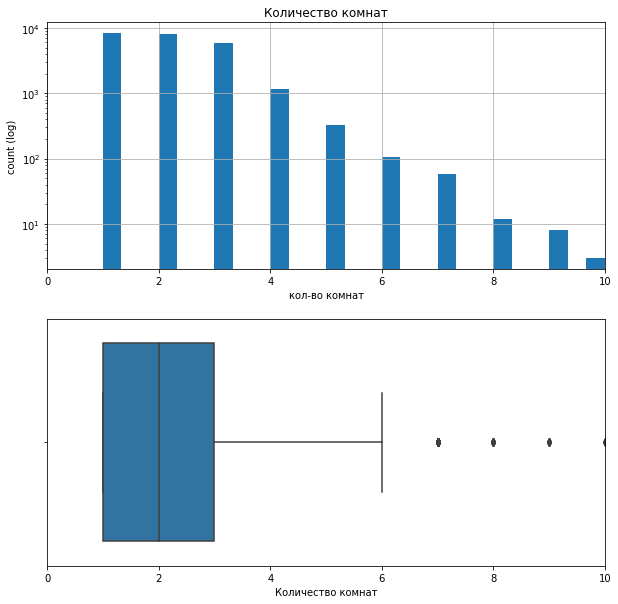

In [79]:
rooms(df, "Количество комнат")

Нулевые значения комнат были заменены на значения относительно площади. Медианное значение составило 2 команты в квартире.

### Высота потолков


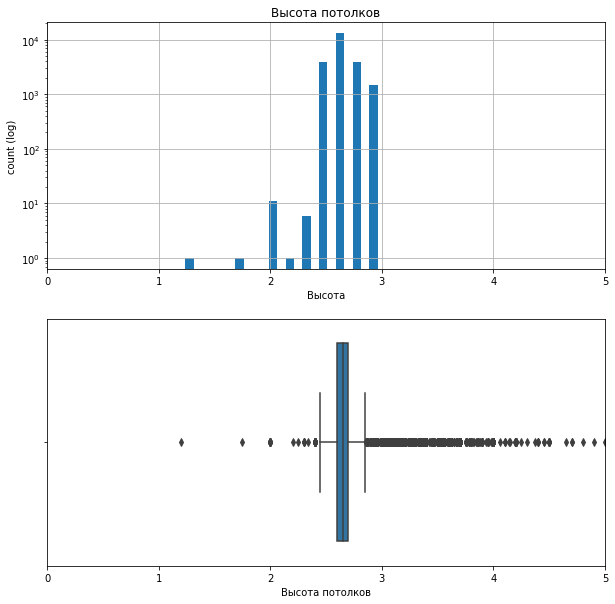

In [80]:
def ceiling_height(df, title):
    plt.subplot(2, 1, 1)
    plt.yscale('log')
    plt.title(title)
    plt.xlabel("Высота")
    plt.ylabel("count (log)")
    df['ceiling_height'].hist(bins = 20, range = (0, 3), rwidth=0.5, figsize=(10,10));
    plt.xlim(0, 5)
    plt.subplot(2, 1, 2, sharex = plt.gca())
    ax=sns.boxplot(df['ceiling_height']);
    ax.set(xlabel='Высота потолков')
    df['ceiling_height'].describe() 
ceiling_height(df, 'Высота потолков')

In [81]:
df.loc[df['ceiling_height']<2]

,total_images,price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_dist,city_centers_dist,parks_3km,parks_dist,ponds_3km,ponds_dist,days_exposition,price_m2,% living_area,% kitchen_area,floor_type,first_day_expo_D,first_day_expo_Y,first_day_expo_M
5712,5,1.5,42,2017-08-14,2,1.20,2,27.5,1,False,False,False,5.20,0,городской посёлок Мга,NaN,NaN,NaN,NaN,NaN,NaN,248.0,35714,1.527273,8.076923,first,1,2017,8
16934,5,4.1,40,2017-10-17,1,1.75,37,17.4,5,False,False,False,8.34,1,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,71.0,102500,2.298851,4.796163,other,2,2017,10


In [82]:
df.loc[df['ceiling_height']<2, 'ceiling_height'] = df['ceiling_height'].median()

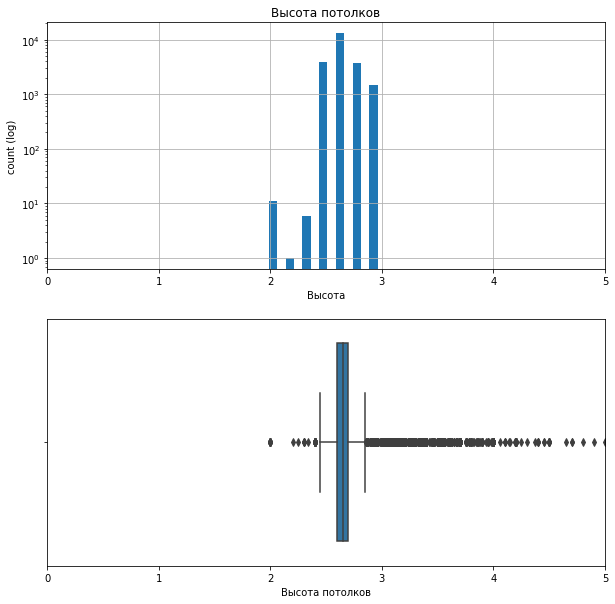

In [83]:
ceiling_height(df, 'Высота потолков')

Были выявлены два объявления с высотой потолков менее 2метров, учитывая что остальные данные в этих объявлениях указаны корректно, скорее всего это ошибка. Высота была заменена на меданное значение.

### Площадь

count    23699.000000
mean        60.120511
std         35.665822
min         12.000000
25%         40.000000
50%         52.000000
75%         69.000000
max        900.000000
Name: total_area, dtype: float64


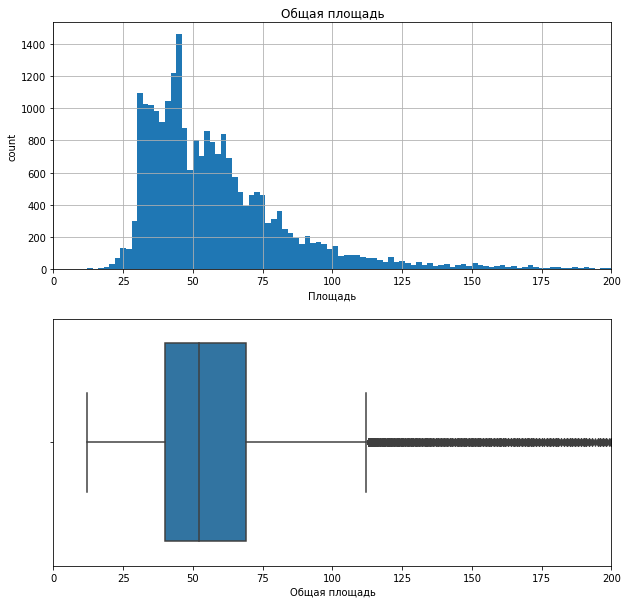

In [84]:
def total_area(df, title):
    print(df['total_area'].describe() )
    plt.subplot(2, 1, 1)
    #plt.yscale('log')
    plt.title(title)
    plt.xlabel("Площадь")
    plt.ylabel("count")
    df['total_area'].hist(bins = 100, range = (0, 200), figsize=(10,10));
    plt.xlim(0, 200)
    ax=plt.subplot(2, 1, 2, sharex = plt.gca())
    ax.set(xlabel='Площадь')
    ax=sns.boxplot(df['total_area']);
    ax.set(xlabel='Общая площадь')
    df['total_area'].describe() 
    
total_area(df, 'Общая площадь')

Основная масса продаваемых квартир от 40 до 69 м2.

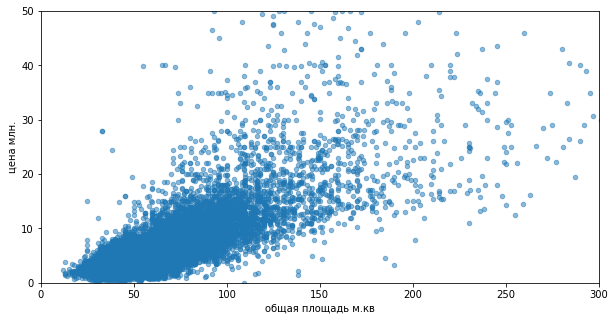

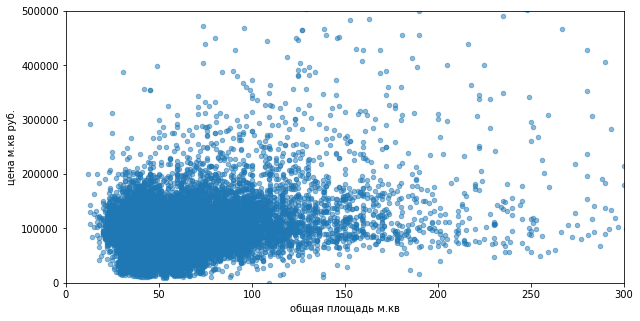

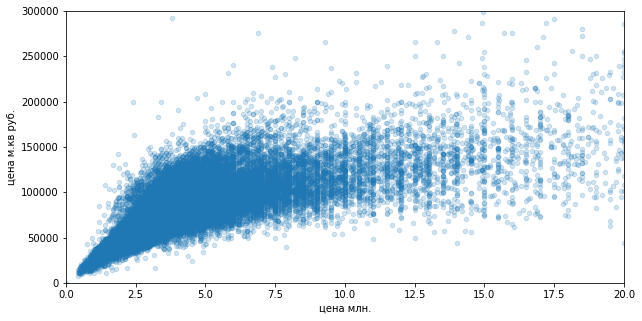

In [85]:
ax=df.plot(kind='scatter', x='total_area', y='price', alpha=0.5, figsize=(10,5), xlim=(0,300), ylim=(0,50));
ax.set_xlabel('общая площадь м.кв');
ax.set_ylabel('цена млн.');
ax=df.plot(kind='scatter', x='total_area', y='price_m2', alpha=0.5, xlim=(0,300), ylim=(0,500000), figsize=(10,5));
ax.set_xlabel('общая площадь м.кв');
ax.set_ylabel('цена м.кв руб.');
ax=df.plot(kind='scatter', x='price', y='price_m2', alpha=0.2, xlim=(0,20), ylim=(0,300000), figsize=(10,5));
ax.set_xlabel('цена млн.');
ax.set_ylabel('цена м.кв руб.');

цена квартиры зависит от общей площади, чем больше площадь, тем выше цена. Так же, наблюдается зависимость цены квадратного метра от общей цены в сегменте квартир до 5 млн.
Вертикальные полосы, которые можно наблюдать на нижнем графике, говорят о склонности продавцов округлять цены дорогих квартир кратно 500т.р. 

### Время продажи квартиры

In [86]:
df.head(10)

,total_images,price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_dist,city_centers_dist,parks_3km,parks_dist,ponds_3km,ponds_dist,days_exposition,price_m2,% living_area,% kitchen_area,floor_type,first_day_expo_D,first_day_expo_Y,first_day_expo_M
0,20,13.000,108,2019-03-07,3,2.70,16,51.00,8,False,False,False,25.000000,1,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,120370,2.117647,4.320000,other,4,2019,3
1,7,3.350,40,2018-12-04,1,2.65,11,18.60,1,False,False,False,11.000000,2,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,83750,2.150538,3.636364,first,2,2018,12
2,10,5.196,56,2015-08-20,2,2.65,5,34.30,4,False,False,False,8.300000,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,92785,1.632653,6.746988,other,4,2015,8
3,0,64.900,159,2015-07-24,3,2.65,14,45.00,9,False,False,False,27.413793,0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,408176,3.533333,5.800000,other,5,2015,7
4,2,10.000,100,2018-06-19,2,3.03,14,32.00,13,False,False,False,41.000000,1,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,100000,3.125000,2.439024,other,2,2018,6
5,10,2.890,30,2018-09-10,1,2.65,12,14.40,5,False,False,False,9.100000,1,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0,96333,2.083333,3.296703,other,1,2018,9
6,6,3.700,37,2017-11-02,1,2.65,26,10.60,6,False,False,False,14.400000,1,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0,100000,3.490566,2.569444,other,4,2017,11
7,5,7.915,71,2019-04-18,2,2.65,24,30.50,22,False,False,False,18.900000,2,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN,111478,2.327869,3.756614,other,4,2019,4
8,20,2.900,33,2018-05-23,1,2.65,27,15.43,26,False,False,False,8.810000,1,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0,87878,2.138691,3.745743,other,3,2018,5
9,18,5.400,61,2017-02-26,3,2.50,9,43.60,7,False,False,False,6.500000,2,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0,88524,1.399083,9.384615,other,7,2017,2


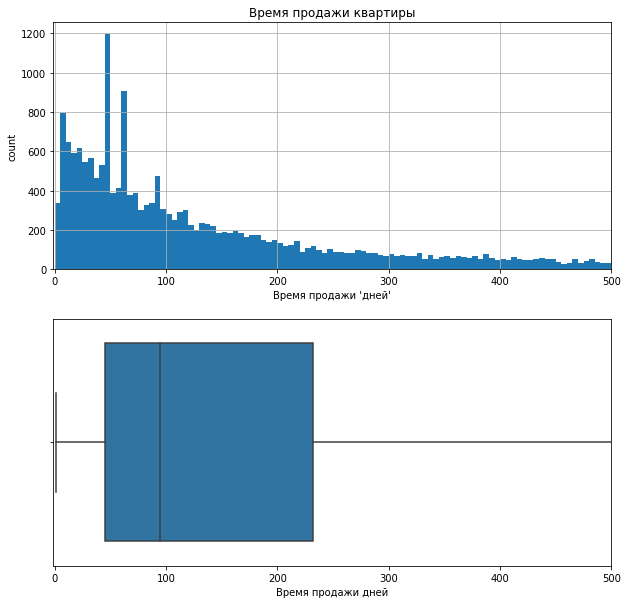

In [87]:
def days_exposition(df):
    plt.subplot(2, 1, 1)
    plt.title("Время продажи квартиры")
    plt.xlabel("Время продажи 'дней'")
    plt.ylabel("count")
    df['days_exposition'].hist(bins = 100, range = (0, 500), figsize=(10,10));
    plt.xlim(-1, 500)
    plt.subplot(2, 1, 2, sharex = plt.gca())
    ax=sns.boxplot(df['days_exposition']);
    ax.set(xlabel='Время продажи дней')
    df['days_exposition'].describe() 
days_exposition(df)



Если считать что время публикации = время продажи квартиры, то основная масса квартир продается за 95 дней, однако в некоторых случаях время может доходить до 232 дней, если больше, то это аномально большой срок, возможно завышена цена, либо иные факторы не позволяющие продать квартиру. Продажи от 1 до 45 дней можно считать очень быстрыми.

### Количество комнат

In [88]:
df['rooms_type'] = pd.cut(df['rooms'],[1,2,3,4,19])
df.groupby('rooms_type')['total_area'].agg(['mean', 'median', 'count'])

,mean,median,count
rooms_type,,,
"(1, 2]",55.666667,53,7950
"(2, 3]",77.543000,73,5814
"(3, 4]",107.394068,99,1180
"(4, 19]",189.681382,165,521


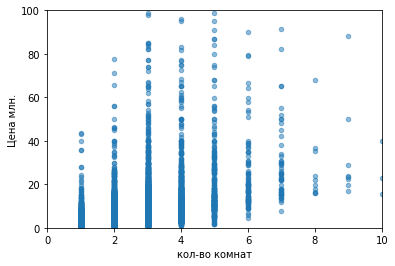

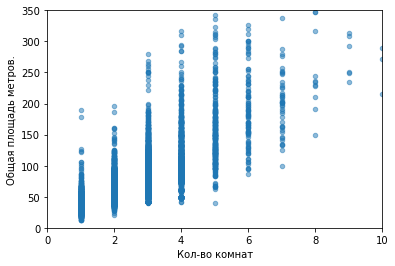

In [89]:
def rooms(df):
    ax = df.plot(kind='scatter', x='rooms', y='price', alpha=0.5, xlim=(0,10), ylim=(0,100))
    ax.set_ylabel("Цена млн.")
    ax.set_xlabel("кол-во комнат")
    ax = df.plot(kind='scatter', y='total_area', x='rooms', alpha=0.5, ylim=(0,350), xlim=(0,10))
    ax.set_ylabel("Общая площадь метров.")
    ax.set_xlabel("Кол-во комнат")
rooms(df)


Кол-во комнат прямо пропорционально общей площади, соответственно цена квартиры напрямую зависит от кол-ва комнат.

### Дистанция от центра города

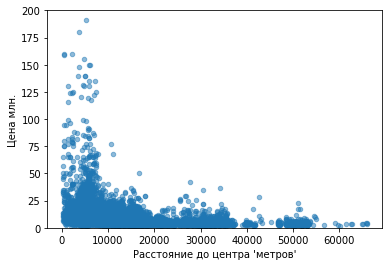

In [90]:
def city_centers_dist(df):
     ax = df.plot(kind='scatter', y='price', x='city_centers_dist', alpha=0.5, ylim=(0,200))
     ax.set_ylabel("Цена млн.")
     ax.set_xlabel("Расстояние до центра 'метров'")
city_centers_dist(df)

Дорогой сегмент квартир распологается в пределах 10км от центра. После 10 км влияние расстояния от цента на цену снижается.

In [91]:
df['city_centers_dist_cut'] = pd.cut(df['city_centers_dist'],20)

Text(0, 0.5, 'цена м.кв. руб.')

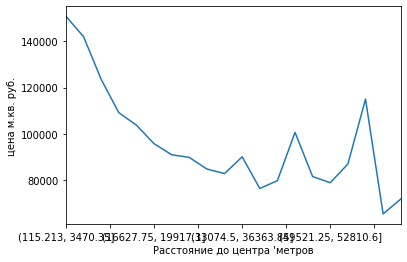

In [92]:
ax=df.groupby('city_centers_dist_cut')['price_m2'].mean().plot()
ax.set_xlabel("Расстояние до центра 'метров")
ax.set_ylabel("цена м.кв. руб.")

дорогой сегмент квартир по цене за квадрат, так же распологается вблизи центра города или в центре.


### Этаж

In [93]:
def floor_type(df):
    print(df.groupby('floor_type')['price','price_m2'].agg(['median', 'count']))
floor_type(df)

            price        price_m2       
           median  count   median  count
floor_type                              
first        3.90   2889    81707   2889
last         4.30   3447    88541   3447
other        4.85  17363    98684  17363


Квартиры на первом этаже продаются реже чем на последнем, предположительно связано с тем, что во многих домах на первых этажах распологается коммерческая недвижимость. Квартриры на первом этаже дешевле квартир на других этажах примерно на 20%, а квартиры на последних этажах дешевле других(кроме первых) на 10%

### Дата публикации

In [94]:
df.groupby('first_day_expo_Y')['price','price_m2'].agg(['median', 'count'])

price       price_m2      
                 median count   median count
first_day_expo_Y                            
2014               7.70   137   107845   137
2015               5.35  1191    93614  1191
2016               4.55  2783    92222  2783
2017               4.50  8190    93181  8190
2018               4.55  8519    96341  8519
2019               5.05  2879   104081  2879

In [95]:
print('месяцы публикаций в 2014:',
      df.loc[df['first_day_expo_Y'] == 2014, 'first_day_expo_M'].unique())
print('месяцы публикаций в 2019:',
      df.loc[df['first_day_expo_Y'] == 2019, 'first_day_expo_M'].unique())


месяцы публикаций в 2014: [12 11]
месяцы публикаций в 2019: [3 4 1 2 5]


Вероятно, сервис по продаже квартир стартовал в ноябре 2014года, данные у нас предоставлены по май 2019. Кол-во объявлений растет с каждым годом, если не учитывать неполные года, цены находятся примерно на одном уровне

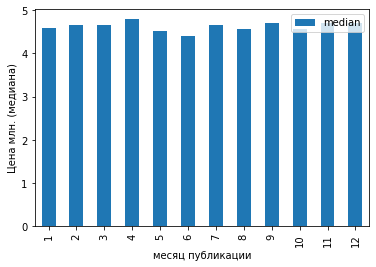

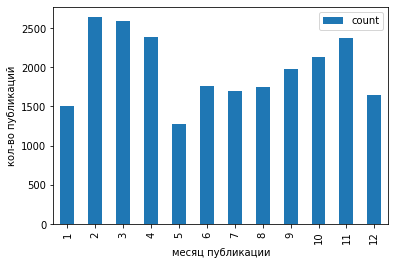

In [96]:
def first_day_expo_M(df):
    df_price_season_median = df.groupby('first_day_expo_M')['price'].agg(['median'])
    ax = df_price_season_median.plot.bar()
    ax.set_xlabel("месяц публикации")
    ax.set_ylabel("Цена млн. (медиана)")
    df_price_season_count = df.groupby('first_day_expo_M')['price'].agg(['count'])
    ax = df_price_season_count.plot.bar()
    ax.set_xlabel("месяц публикации")
    ax.set_ylabel("кол-во публикаций")
first_day_expo_M(df)

минамальное кол-во обьявлений публикуется в декабре, январе и мае, в летние месяца наблюдется низкий сезон продажи квартир, в зимние высокий, за исключением новогодних праздников.  
Цена в летние месяцы незначительно снижается. 

In [97]:
def first_day_expo_D(df):
    print(df.groupby('first_day_expo_D')['price'].agg(['median', 'count']))
    print(df.groupby('first_day_expo_D')['price_m2'].agg(['median', 'count']))
first_day_expo_D(df)

                  median  count
first_day_expo_D               
1                  4.650   3612
2                  4.730   4183
3                  4.700   3974
4                  4.650   4295
5                  4.585   4000
6                  4.555   1936
7                  4.550   1699
                   median  count
first_day_expo_D                
1                 95244.5   3612
2                 96103.0   4183
3                 96052.0   3974
4                 95555.0   4295
5                 95000.0   4000
6                 94058.5   1936
7                 94927.0   1699


Цена в зависимости от дня недели меняется - самые дешевые квартиры публикуются в выходные, а так же меняется кол-во публикаций. Могу сделать предположения:
1. в буднии дни значительно больше публикаций по сравнению с выходными потому что их размещают агенства недвижимости, а в выходные больше - собственники
2. собственники выставляют квартиры по цене дешевле чем агенства


## ТОП10 локаций по кол-ву объявлений

In [98]:
top10_localiti = df.groupby('locality_name').agg({'price_m2':['mean', 'count']}).sort_values(by=('price_m2', 'count'), ascending=False).head(10)

top10_localiti.sort_values(by=('price_m2', 'mean'), ascending=False)

    

price_m2       
                            mean  count
locality_name                          
Санкт-Петербург    115335.122357  15749
Пушкин             103610.948509    369
деревня Кудрово     93001.742475    299
посёлок Парголово   90675.235474    327
посёлок Мурино      86379.549808    522
посёлок Шушары      79068.186364    440
Колпино             75735.150888    338
Гатчина             69045.068404    307
Всеволожск          68984.801508    398
Выборг              58295.691983    237

Среди топ10 по кол-ву объявлений населенных пунктов, самым дорогим по средней цене квадратного метра является г. Санкт-Петербург, самым дешевым г. Выборг

In [99]:
df.head()

,total_images,price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_dist,city_centers_dist,parks_3km,parks_dist,ponds_3km,ponds_dist,days_exposition,price_m2,% living_area,% kitchen_area,floor_type,first_day_expo_D,first_day_expo_Y,first_day_expo_M,rooms_type,city_centers_dist_cut
0,20,13.000,108,2019-03-07,3,2.70,16,51.0,8,False,False,False,25.000000,1,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,120370,2.117647,4.320000,other,4,2019,3,"(2.0, 3.0]","(13338.4, 16627.75]"
1,7,3.350,40,2018-12-04,1,2.65,11,18.6,1,False,False,False,11.000000,2,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,83750,2.150538,3.636364,first,2,2018,12,NaN,"(16627.75, 19917.1]"
2,10,5.196,56,2015-08-20,2,2.65,5,34.3,4,False,False,False,8.300000,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,92785,1.632653,6.746988,other,4,2015,8,"(1.0, 2.0]","(13338.4, 16627.75]"
3,0,64.900,159,2015-07-24,3,2.65,14,45.0,9,False,False,False,27.413793,0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,408176,3.533333,5.800000,other,5,2015,7,"(2.0, 3.0]","(6759.7, 10049.05]"
4,2,10.000,100,2018-06-19,2,3.03,14,32.0,13,False,False,False,41.000000,1,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,100000,3.125000,2.439024,other,2,2018,6,"(1.0, 2.0]","(6759.7, 10049.05]"


## Изучение квартрир в центре

### Определение центра города

In [100]:
df['city_centers_km'] = df['city_centers_dist'] // 1000
df_centr = df.loc[df['locality_name']=='Санкт-Петербург']

df_centr
  

,total_images,price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_dist,city_centers_dist,parks_3km,parks_dist,ponds_3km,ponds_dist,days_exposition,price_m2,% living_area,% kitchen_area,floor_type,first_day_expo_D,first_day_expo_Y,first_day_expo_M,rooms_type,city_centers_dist_cut,city_centers_km
0,20,13.000,108,2019-03-07,3,2.70,16,51.0,8,False,False,False,25.000000,1,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,120370,2.117647,4.320000,other,4,2019,3,"(2.0, 3.0]","(13338.4, 16627.75]",16.0
2,10,5.196,56,2015-08-20,2,2.65,5,34.3,4,False,False,False,8.300000,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,92785,1.632653,6.746988,other,4,2015,8,"(1.0, 2.0]","(13338.4, 16627.75]",13.0
3,0,64.900,159,2015-07-24,3,2.65,14,45.0,9,False,False,False,27.413793,0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,408176,3.533333,5.800000,other,5,2015,7,"(2.0, 3.0]","(6759.7, 10049.05]",6.0
4,2,10.000,100,2018-06-19,2,3.03,14,32.0,13,False,False,False,41.000000,1,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,100000,3.125000,2.439024,other,2,2018,6,"(1.0, 2.0]","(6759.7, 10049.05]",8.0
7,5,7.915,71,2019-04-18,2,2.65,24,30.5,22,False,False,False,18.900000,2,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN,111478,2.327869,3.756614,other,4,2019,4,"(1.0, 2.0]","(10049.05, 13338.4]",11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23689,13,3.550,35,2018-02-28,1,2.86,15,16.3,4,False,False,False,9.100000,2,Санкт-Петербург,17284.0,16081.0,1.0,353.0,2.0,652.0,29.0,101428,2.147239,3.846154,other,3,2018,2,NaN,"(13338.4, 16627.75]",16.0
23690,3,5.500,52,2018-07-19,2,2.65,5,31.0,2,False,False,False,6.000000,1,Санкт-Петербург,20151.0,6263.0,1.0,300.0,0.0,NaN,15.0,105769,1.677419,8.666667,other,4,2018,7,"(1.0, 2.0]","(3470.35, 6759.7]",6.0
23691,11,9.470,72,2016-10-13,2,2.75,25,40.3,7,False,False,False,10.600000,1,Санкт-Петербург,19424.0,4489.0,0.0,NaN,1.0,806.0,519.0,131527,1.786600,6.792453,other,4,2016,10,"(1.0, 2.0]","(3470.35, 6759.7]",4.0
23694,9,9.700,133,2017-03-21,3,3.70,5,73.3,3,False,False,False,13.830000,1,Санкт-Петербург,24665.0,4232.0,1.0,796.0,3.0,381.0,NaN,72932,1.814461,9.616775,other,2,2017,3,"(2.0, 3.0]","(3470.35, 6759.7]",4.0


In [101]:
df_centr = df_centr.groupby('city_centers_km').agg({'price':['mean']})
df_centr

,price
,mean
city_centers_km,
0.0,23.442315
1.0,18.843572
2.0,16.163314
3.0,13.409854
4.0,13.579417
5.0,15.293386
6.0,14.389106
7.0,12.797674


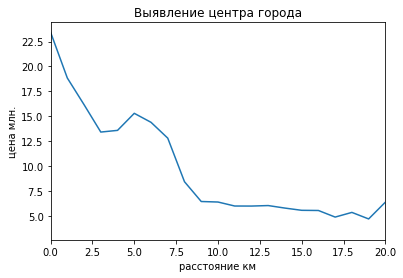

In [102]:
plt.xlim([0, 20])
plt.title('Выявление центра города')
plt.xlabel('расстояние км')
plt.ylabel('цена млн.')
plt.plot(df_centr);
plt.show()

В радиусе 8 км. находятся самые дорогие квартиры, этот район можно обозначить как центр города.


In [103]:
centr = df.loc[df['city_centers_dist'] < 8000]
centr

,total_images,price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_dist,city_centers_dist,parks_3km,parks_dist,ponds_3km,ponds_dist,days_exposition,price_m2,% living_area,% kitchen_area,floor_type,first_day_expo_D,first_day_expo_Y,first_day_expo_M,rooms_type,city_centers_dist_cut,city_centers_km
3,0,64.900,159,2015-07-24,3,2.65,14,45.0,9,False,False,False,27.413793,0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,408176,3.533333,5.800000,other,5,2015,7,"(2.0, 3.0]","(6759.7, 10049.05]",6.0
24,8,6.500,97,2015-10-31,2,2.65,3,46.5,1,False,False,False,19.600000,0,Санкт-Петербург,20052.0,2336.0,3.0,411.0,3.0,124.0,265.0,67010,2.086022,4.948980,first,6,2015,10,"(1.0, 2.0]","(115.213, 3470.35]",2.0
35,6,15.500,149,2017-06-26,5,2.65,5,104.0,4,False,False,False,17.000000,1,Санкт-Петербург,23670.0,3502.0,0.0,NaN,1.0,779.0,644.0,104026,1.432692,8.764706,other,1,2017,6,"(4.0, 19.0]","(3470.35, 6759.7]",3.0
51,7,45.000,161,2017-10-17,3,3.20,8,38.0,4,False,False,False,50.000000,1,Санкт-Петербург,32537.0,6589.0,0.0,NaN,3.0,99.0,541.0,279503,4.236842,3.220000,other,2,2017,10,"(2.0, 3.0]","(3470.35, 6759.7]",6.0
52,20,11.795,136,2017-09-22,6,3.00,2,94.0,2,False,False,False,11.000000,1,Санкт-Петербург,16510.0,6582.0,1.0,526.0,0.0,NaN,NaN,86727,1.446809,12.363636,last,5,2017,9,"(4.0, 19.0]","(3470.35, 6759.7]",6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23665,11,4.250,47,2016-05-20,1,2.65,6,18.2,1,False,False,False,14.600000,0,Санкт-Петербург,20503.0,4946.0,2.0,624.0,1.0,519.0,131.0,90425,2.582418,3.219178,first,5,2016,5,NaN,"(3470.35, 6759.7]",4.0
23681,13,5.250,43,2018-05-11,2,2.50,5,29.0,2,False,False,False,6.000000,1,Санкт-Петербург,28323.0,7262.0,1.0,497.0,2.0,660.0,80.0,122093,1.482759,7.166667,other,5,2018,5,"(1.0, 2.0]","(6759.7, 10049.05]",7.0
23690,3,5.500,52,2018-07-19,2,2.65,5,31.0,2,False,False,False,6.000000,1,Санкт-Петербург,20151.0,6263.0,1.0,300.0,0.0,NaN,15.0,105769,1.677419,8.666667,other,4,2018,7,"(1.0, 2.0]","(3470.35, 6759.7]",6.0
23691,11,9.470,72,2016-10-13,2,2.75,25,40.3,7,False,False,False,10.600000,1,Санкт-Петербург,19424.0,4489.0,0.0,NaN,1.0,806.0,519.0,131527,1.786600,6.792453,other,4,2016,10,"(1.0, 2.0]","(3470.35, 6759.7]",4.0


### Общая площадь(центр)

count    3728.000000
mean       92.080472
std        60.451112
min        12.000000
25%        56.000000
50%        77.000000
75%       108.000000
max       900.000000
Name: total_area, dtype: float64


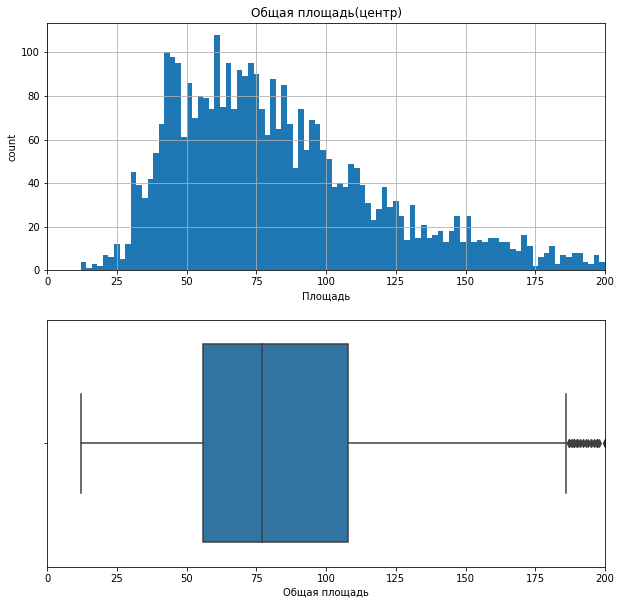

In [104]:
total_area(centr, "Общая площадь(центр)")

Общая площадь квартир в центре значительно выше значений по городу, медианное значение по городу 52м, в центре 80м.

### Цена (центр)

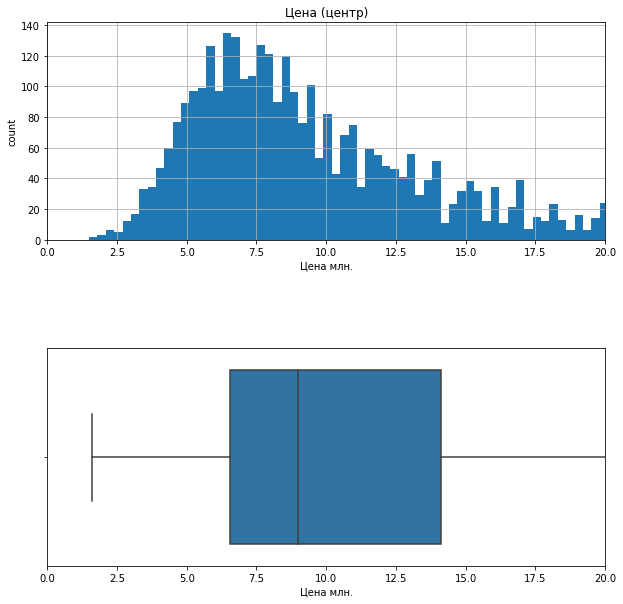

In [105]:
price(centr, 'Цена (центр)')


Квартиры в центре ожидаемо дороже чем в среднем по городу. Если основная масса квартир по городу продается в диапазоне от 3.4 млн до 6.7 млн., то в центре цены стартуют от 6.7 и достигают цен до 15 млн. не считая редких исключений.

### Кол-во комнат(центр)

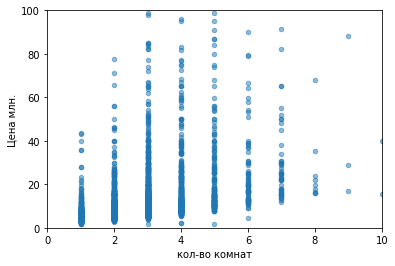

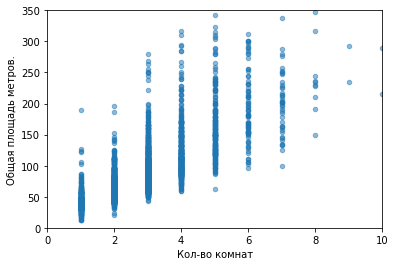

In [106]:
rooms(centr)

Вслед за площадью и ценой, в центре квартриры с большим кол-вом комнат, медианное значение равно трем комнатам, в то время как по городу 2 комнаты. В центре каждая дополнительная комната значительно увеличивает общую площадь квартиры, соответственно тенденция чем больше комнат тем выше цена увеличивается.

### Высота потолков (центр)

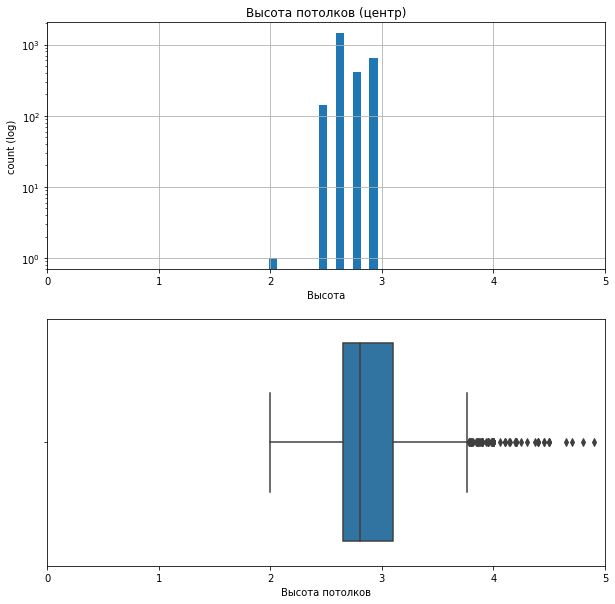

In [107]:
ceiling_height(centr,'Высота потолков (центр)')

высота потолков так же, отличается в большую сторону

### Расстояние до центра (центр)

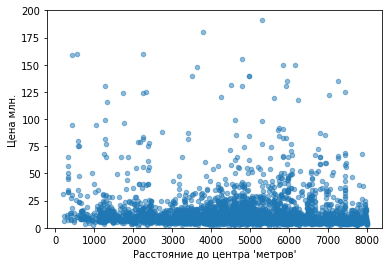

In [108]:
city_centers_dist(centr)

Внутри центра(радиус 7км) цена не зависит от расположения от центра

### Тип этажа(центр)

In [109]:
floor_type(centr)
floor_type(df)

            price       price_m2      
           median count   median count
floor_type                            
first         6.5   409   108695   409
last          9.2   662   117683   662
other         9.5  2657   127868  2657
            price        price_m2       
           median  count   median  count
floor_type                              
first        3.90   2889    81707   2889
last         4.30   3447    88541   3447
other        4.85  17363    98684  17363


Распределение цен по типу этажа в центре не отличается от остального города

### Дата публикации объявления (центр)

In [110]:
first_day_expo_D(centr)


                  median  count
first_day_expo_D               
1                  9.325    562
2                  9.000    633
3                  9.000    641
4                  9.225    766
5                  8.990    633
6                  8.525    282
7                  9.200    211
                    median  count
first_day_expo_D                 
1                 126033.0    562
2                 121052.0    633
3                 124590.0    641
4                 121592.5    766
5                 125000.0    633
6                 128567.0    282
7                 129032.0    211


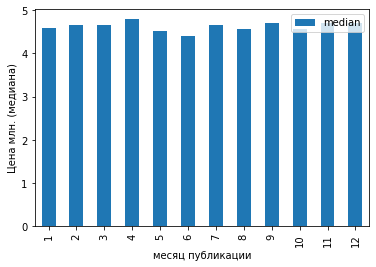

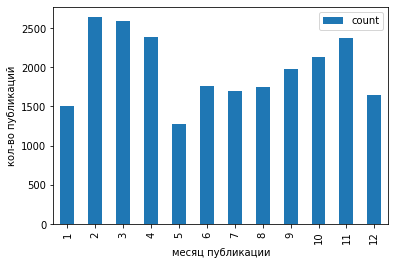

In [111]:
first_day_expo_M(df)

Дата размещения объявления о продаже в квартире в центре так же влияет на цену и ко-во объявлений как и по городу в целом.

## Вывод

Для определения рыночной стоимости объекта необходимо учитывать следующие параметры: 
- Общая площадь. 
- Число комнат. Так же зависит от площади и влияет на цену квартиры.
- Удаленность от центра. В г. Санкт-Петербург можно выделить центр в радиусе 8км, далее зависимость цены от удаленности падает.
- Тип этажа. Первые и последние этажи дешевле прочих.
- Месяц и день недели размещения объявления. 

Некоторое переменные имеют пропуски и артефакты, которые необходимо будет учесть при построении 
автоматизированной системы.